# Model to classify 20 tree species based on LeafSnap data subset

### Settings

In [1]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

Using TensorFlow backend.


### Load the data and split into train, test and validation

In [2]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-20subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (3283, 64, 64, 3)
Labels one hot size:  (3283, 20)
Number of images:  3283


,filename,label,source,label_numeric,path
3278,13002204347915.jpg,Salix nigra,field,14,dataset/images/field/salix_nigra/1300220434791...
3279,wb1193-06-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
3280,13002204347905.jpg,Salix nigra,field,14,dataset/images/field/salix_nigra/1300220434790...
3281,wb1220-03-2.jpg,Magnolia acuminata,lab,7,dataset/images/lab/Auto_cropped/magnolia_acumi...
3282,pi2201-01-1.jpg,Diospyros virginiana,lab,6,dataset/images/lab/Auto_cropped/diospyros_virg...


### Split the data into train, test and validation

In [3]:
[images_train, images_val, images_test, 
 labels_one_hot_train, labels_one_hot_val, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
print('Image size - valid. set: ', np.shape(images_val))
print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    

Image size - train set:  (2298, 64, 64, 3)
Labels size - train set:  (2298, 20)
Image size - valid. set:  (328, 64, 64, 3)
Labels size - valid. set:  (328, 20)
Image size - test set:  (657, 64, 64, 3)
Labels size - test set:  (657, 20)
Indicies:  2298 ,  2626


In [4]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

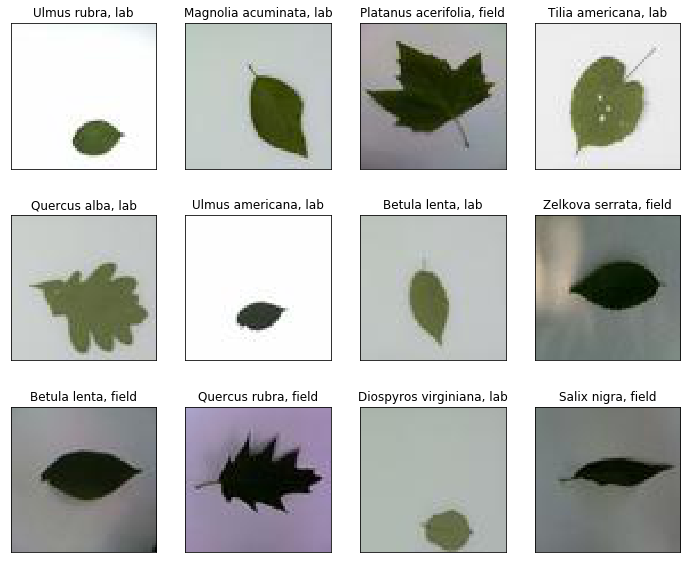

In [5]:
# plot random train images
d.plot_12images(images_train, labels_train, sources_train, figsize=(12,10))

### Data formatting

In [6]:
img_rows = 64
img_cols = 64
img_channels = 3
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (2298, 64, 64, 3)
Size of validation data:  (328, 64, 64, 3)
Size of testing data:  (657, 64, 64, 3)


## Construct the model

In [7]:
model = m.generate_model(input_shape, 20)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 32)        2432      
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 64)        51264     
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 10816)             0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 1000)              10817000  
__________

### Train the model

In [8]:
from keras.callbacks import ModelCheckpoint

# autosave best Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
batch_size = 32
epochs = 100
model, results = m.train_model(model, images_train, labels_one_hot_train,
                             images_val, labels_one_hot_val, 
                             batch_size, epochs, best_model)
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Training model...
Train on 2298 samples, validate on 328 samples
Epoch 1/100
2298/2298 [==============================] - 22s 10ms/step - loss: 2.9577 - acc: 0.0970 - val_loss: 2.8903 - val_acc: 0.0976

Epoch 00001: val_loss improved from inf to 2.89035, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 2/100
2298/2298 [==============================] - 21s 9ms/step - loss: 2.7354 - acc: 0.1823 - val_loss: 2.5352 - val_acc: 0.2134

Epoch 00002: val_loss improved from 2.89035 to 2.53516, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 3/100
2298/2298 [==============================] - 22s 9ms/step - loss: 2.4487 - acc: 0.2576 - val_loss: 2.3693 - val_acc: 0.2591

Epoch 00003: val_loss improved from 2.53516 to 2.36926, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 4/100
2298/2298 [==============================] - 27s 12ms/step 

2298/2298 [==============================] - 23s 10ms/step - loss: 0.6142 - acc: 0.7933 - val_loss: 1.1949 - val_acc: 0.6250

Epoch 00033: val_loss did not improve from 1.12237
Epoch 34/100
2298/2298 [==============================] - 21s 9ms/step - loss: 0.5439 - acc: 0.8238 - val_loss: 1.1510 - val_acc: 0.6463

Epoch 00034: val_loss did not improve from 1.12237
Epoch 35/100
2298/2298 [==============================] - 21s 9ms/step - loss: 0.5130 - acc: 0.8333 - val_loss: 1.1953 - val_acc: 0.6372

Epoch 00035: val_loss did not improve from 1.12237
Epoch 36/100
2298/2298 [==============================] - 23s 10ms/step - loss: 0.5302 - acc: 0.8259 - val_loss: 1.1249 - val_acc: 0.6433

Epoch 00036: val_loss did not improve from 1.12237
Epoch 37/100
2298/2298 [==============================] - 22s 10ms/step - loss: 0.5042 - acc: 0.8264 - val_loss: 1.2290 - val_acc: 0.6463

Epoch 00037: val_loss did not improve from 1.12237
Epoch 38/100
2298/2298 [==============================] - 20s 9ms

2298/2298 [==============================] - 21s 9ms/step - loss: 0.2676 - acc: 0.9099 - val_loss: 1.3479 - val_acc: 0.6555

Epoch 00075: val_loss did not improve from 1.04224
Epoch 76/100
2298/2298 [==============================] - 26s 11ms/step - loss: 0.2551 - acc: 0.9156 - val_loss: 1.2611 - val_acc: 0.6555

Epoch 00076: val_loss did not improve from 1.04224
Epoch 77/100
2298/2298 [==============================] - 26s 11ms/step - loss: 0.2642 - acc: 0.9169 - val_loss: 1.2068 - val_acc: 0.6860

Epoch 00077: val_loss did not improve from 1.04224
Epoch 78/100
2298/2298 [==============================] - 23s 10ms/step - loss: 0.2305 - acc: 0.9243 - val_loss: 1.3592 - val_acc: 0.6707

Epoch 00078: val_loss did not improve from 1.04224
Epoch 79/100
2298/2298 [==============================] - 23s 10ms/step - loss: 0.2730 - acc: 0.9186 - val_loss: 1.2962 - val_acc: 0.6829

Epoch 00079: val_loss did not improve from 1.04224
Epoch 80/100
2298/2298 [==============================] - 22s 10

### Test the model

In [9]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0053772831979226
Test accuracy: 0.7275494676383845


### Examine training process

In [10]:
print(results)

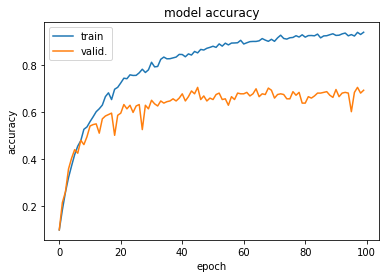

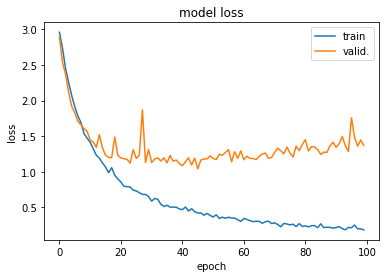

In [11]:
from matplotlib import pyplot as plt

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper right')
plt.show()